In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import f, ttest_ind, chi2_contingency

# 1. Datasets

In [2]:
group_data = pd.read_csv('/Users/wuchenhong/Documents/BIA_courses/BIA686/BIA_686_Team1-master/output/result.csv')

In [3]:
specific_data = pd.read_csv('/Users/wuchenhong/Documents/BIA_courses/BIA686/BIA_686_Team1-master/output/final_data.csv')

In [4]:
print(group_data.shape)
group_data.isnull().sum()

(225, 21)


Topic_Year               0
Citation_feature         0
Topic_num                0
Five_Year_Percent        0
Three_Year_Percent       0
Sum_SJR                  0
Avg_SJR                  0
Year                     0
Topic                    0
Growth_Rate              0
Citation_Growth_Rate     0
Year_Growth_Rate         0
Target                   0
Avg_SJR_1                0
Avg_SJR_2                0
Avg_SJR_3               15
Sum_SJR_1                0
Sum_SJR_2                0
Sum_SJR_3               15
Google Trend             0
Review_AMT               0
dtype: int64

In [5]:
print(specific_data.shape)
specific_data.isnull().sum()

(46169, 13)


Cluster_Topic                       0
PY                                  0
Topic_Year                          0
PT                                  0
PG                                  0
Have_Funding_Agency                 0
Author_count                        0
Funding_agency_count                0
Squeezed_Publisher                  0
Contain_Top_All_authors             0
Contain_Top_All_funding_agencies    0
Count_of_top_funding_agency         0
Contain_Top_PU                      0
dtype: int64

In [6]:
# Merge two datasets into one by key 'Topic_Year'
final_data = group_data.merge(specific_data, how='right', on='Topic_Year')

In [7]:
del group_data
del specific_data

In [8]:
# Filter data after year 2000
final_data = final_data[(final_data.PY >= 2000) & (final_data.PY < 2019)]

In [9]:
# Remove overlapped features
final_data.drop(columns=['PY','Cluster_Topic'], inplace=True)
final_data.isnull().sum()

Topic_Year                             0
Citation_feature                    2669
Topic_num                           2669
Five_Year_Percent                   2669
Three_Year_Percent                  2669
Sum_SJR                             2669
Avg_SJR                             2669
Year                                2669
Topic                               2669
Growth_Rate                         2669
Citation_Growth_Rate                2669
Year_Growth_Rate                    2669
Target                              2669
Avg_SJR_1                           2669
Avg_SJR_2                           2669
Avg_SJR_3                           3643
Sum_SJR_1                           2669
Sum_SJR_2                           2669
Sum_SJR_3                           3643
Google Trend                        2669
Review_AMT                          2669
PT                                     0
PG                                     0
Have_Funding_Agency                    0
Author_count    

In [10]:
# Missing data imputation by replacing median values
missing_cols = []
for col in final_data.columns:
    if final_data[col].isnull().sum() != 0:
        missing_cols.append(col)

In [11]:
missing_cols

['Citation_feature',
 'Topic_num',
 'Five_Year_Percent',
 'Three_Year_Percent',
 'Sum_SJR',
 'Avg_SJR',
 'Year',
 'Topic',
 'Growth_Rate',
 'Citation_Growth_Rate',
 'Year_Growth_Rate',
 'Target',
 'Avg_SJR_1',
 'Avg_SJR_2',
 'Avg_SJR_3',
 'Sum_SJR_1',
 'Sum_SJR_2',
 'Sum_SJR_3',
 'Google Trend',
 'Review_AMT']

In [12]:
for missing_col in missing_cols:
    final_data[missing_col].fillna(np.nanmedian(final_data[missing_col]), inplace=True)

In [13]:
final_data.isnull().sum()

Topic_Year                          0
Citation_feature                    0
Topic_num                           0
Five_Year_Percent                   0
Three_Year_Percent                  0
Sum_SJR                             0
Avg_SJR                             0
Year                                0
Topic                               0
Growth_Rate                         0
Citation_Growth_Rate                0
Year_Growth_Rate                    0
Target                              0
Avg_SJR_1                           0
Avg_SJR_2                           0
Avg_SJR_3                           0
Sum_SJR_1                           0
Sum_SJR_2                           0
Sum_SJR_3                           0
Google Trend                        0
Review_AMT                          0
PT                                  0
PG                                  0
Have_Funding_Agency                 0
Author_count                        0
Funding_agency_count                0
Squeezed_Pub

In [14]:
final_data[final_data.columns[0:11]].head(5)

,Topic_Year,Citation_feature,Topic_num,Five_Year_Percent,Three_Year_Percent,Sum_SJR,Avg_SJR,Year,Topic,Growth_Rate,Citation_Growth_Rate
0,0_2004,0.001447,69.0,0.245223,0.351598,62.657,0.813727,2004.0,0.0,-0.054795,0.487075
1,0_2004,0.001447,69.0,0.245223,0.351598,62.657,0.813727,2004.0,0.0,-0.054795,0.487075
2,0_2004,0.001447,69.0,0.245223,0.351598,62.657,0.813727,2004.0,0.0,-0.054795,0.487075
3,0_2004,0.001447,69.0,0.245223,0.351598,62.657,0.813727,2004.0,0.0,-0.054795,0.487075
4,0_2004,0.001447,69.0,0.245223,0.351598,62.657,0.813727,2004.0,0.0,-0.054795,0.487075


In [15]:
final_data[final_data.columns[11:23]].head(5)

,Year_Growth_Rate,Target,Avg_SJR_1,Avg_SJR_2,Avg_SJR_3,Sum_SJR_1,Sum_SJR_2,Sum_SJR_3,Google Trend,Review_AMT,PT,PG
0,0.160839,0.0,1.020058,1.056329,1.127735,70.384,77.112,179.053,0.480263,4.0,J,9
1,0.160839,0.0,1.020058,1.056329,1.127735,70.384,77.112,179.053,0.480263,4.0,J,7
2,0.160839,0.0,1.020058,1.056329,1.127735,70.384,77.112,179.053,0.480263,4.0,J,7
3,0.160839,0.0,1.020058,1.056329,1.127735,70.384,77.112,179.053,0.480263,4.0,J,7
4,0.160839,0.0,1.020058,1.056329,1.127735,70.384,77.112,179.053,0.480263,4.0,J,13


In [16]:
final_data[final_data.columns[23:]].head(5)

,Have_Funding_Agency,Author_count,Funding_agency_count,Squeezed_Publisher,Contain_Top_All_authors,Contain_Top_All_funding_agencies,Count_of_top_funding_agency,Contain_Top_PU
0,0,3,0,Other Publishers,0.0,0.0,0,0.0
1,0,4,0,Other Publishers,0.0,0.0,0,0.0
2,0,6,0,Other Publishers,0.0,0.0,0,0.0
3,0,8,0,ELSEVIER SCIENCE BV,0.0,0.0,0,1.0
4,0,4,0,ELSEVIER SCIENCE BV,0.0,0.0,0,1.0


# 2. Feature Selection - Visualization & Hypothesis testing
- **2.1 Distribution plots - numerical features VS response**
- **2.2 Relationship between numerical predictors: Correlation Plot**
- **2.3 Distribution plots - categorical features**
- **2.4 Hypothesis testing - two sample t-test for numerical features**
- **2.5 Hypothesis testing - chi-square test for categorical features**
- **2.6 Overall feature selection summary**

## 2.1 Distribution plots - numerical features VS response

In [17]:
# Helper function for inspecting the relationship between numerical features 
# and the response variable.
def num_feature_distribution_plot(col_name, response_name, data):
    plt.figure(figsize = (10, 8))

    # KDE plot of y = 0 
    sb.kdeplot(data.loc[data[response_name] == 0, col_name], label = '0')
    
    # KDE plot of y = 1 
    sb.kdeplot(data.loc[data[response_name] == 1, col_name], label = '1')

    # Labeling
    plt.xlabel(col_name)
    plt.title('Distribution of '+ col_name, fontsize=20)

/Users/wuchenhong/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


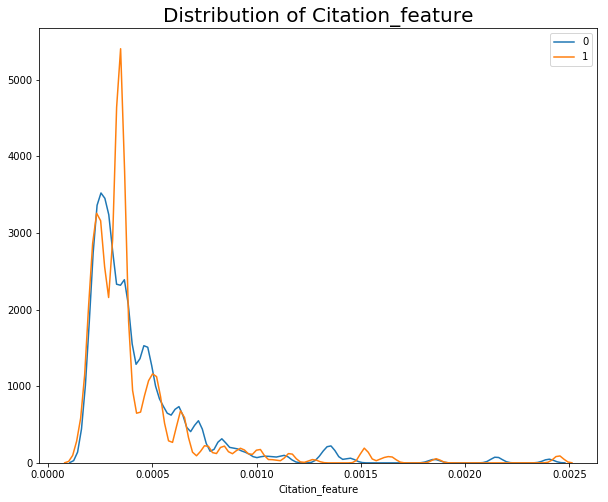

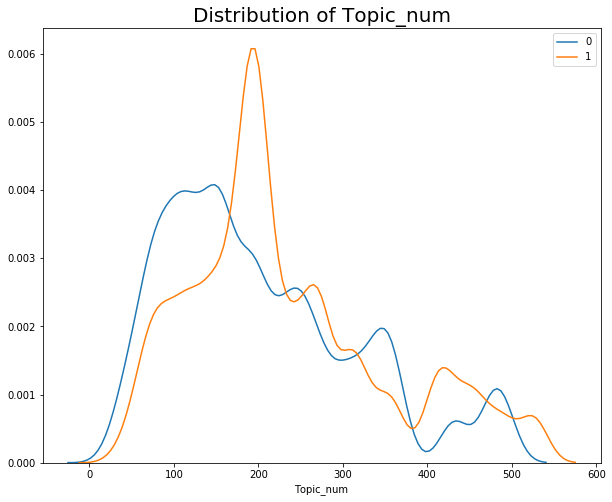

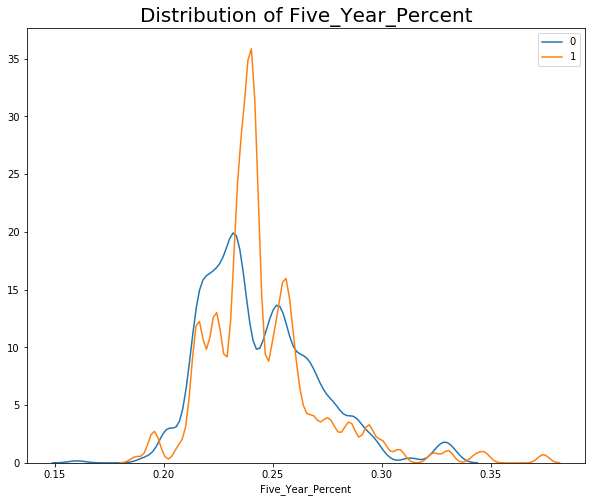

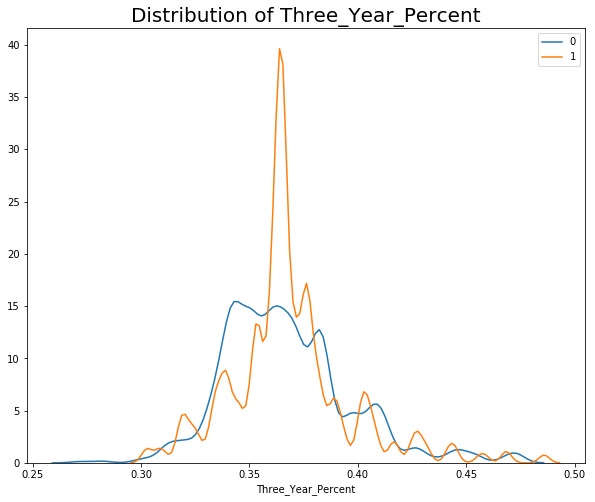

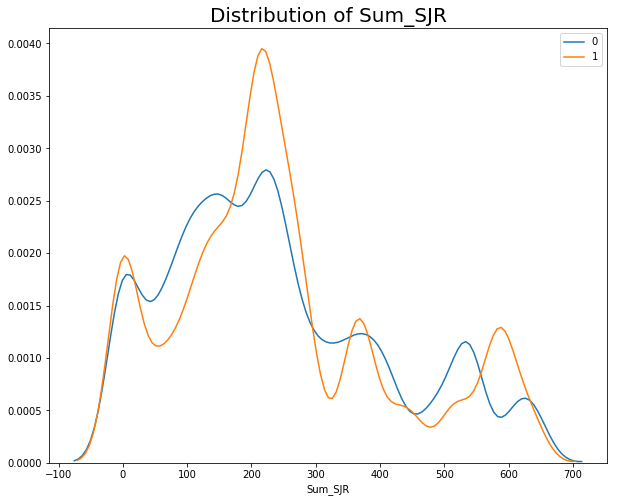

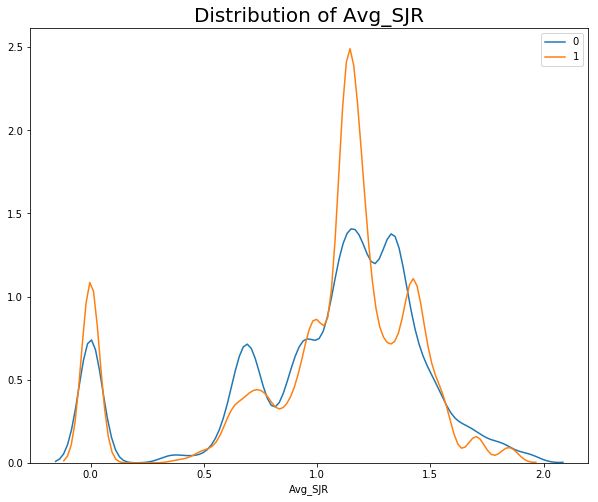

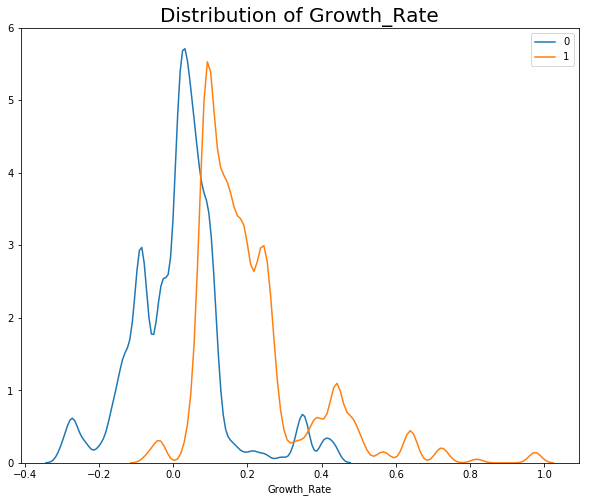

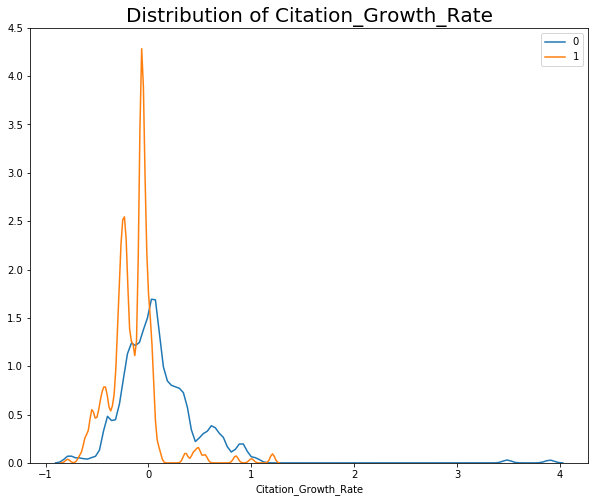

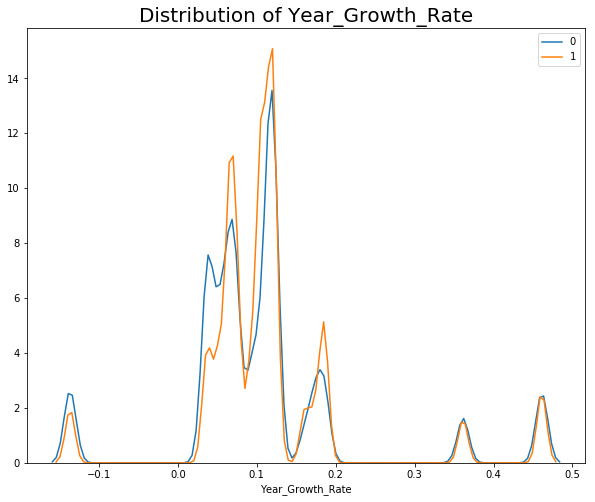

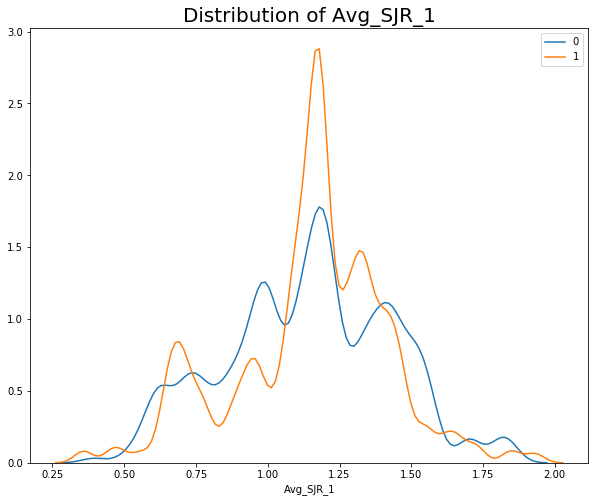

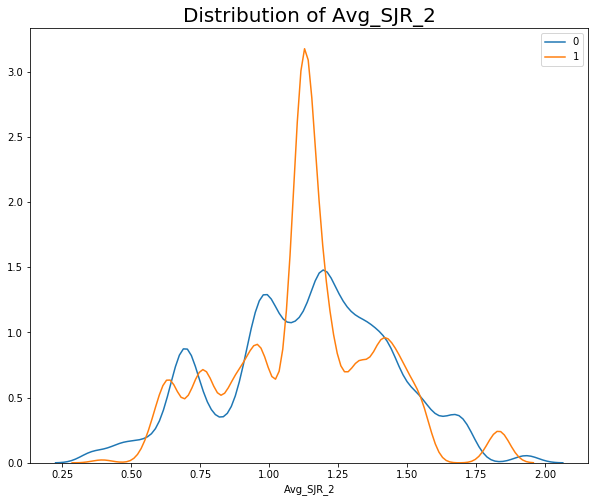

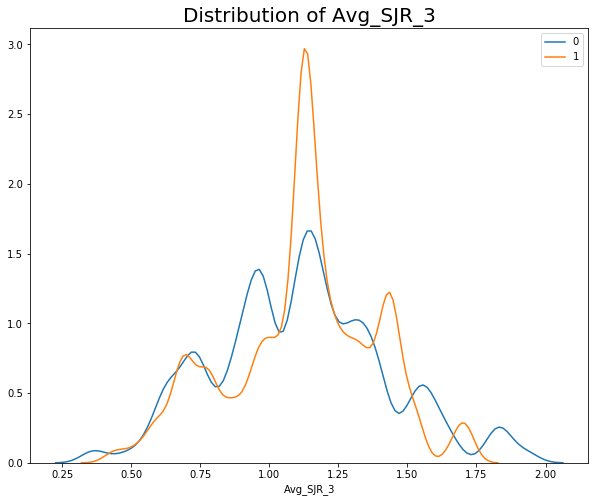

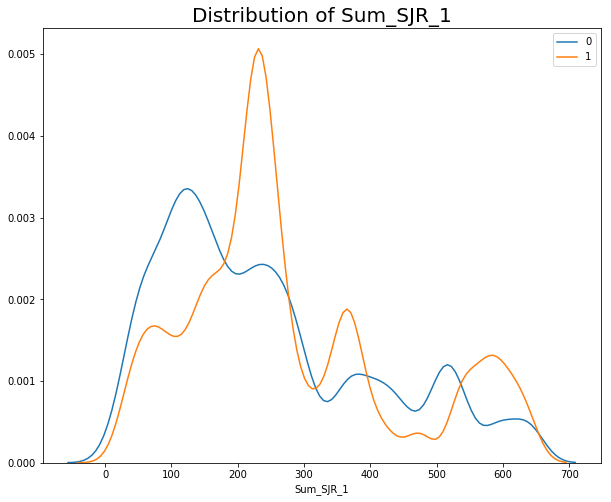

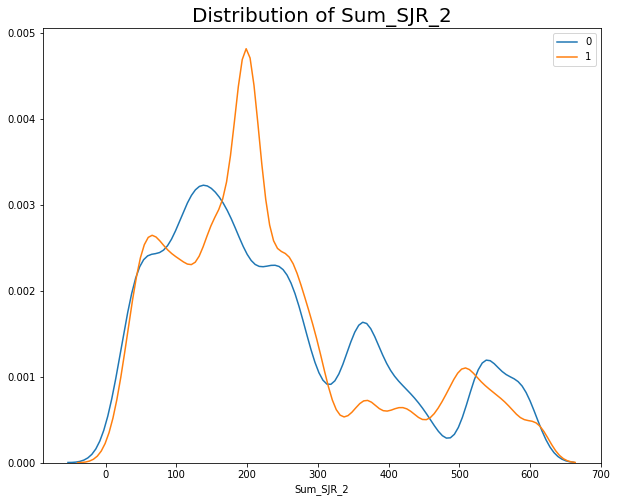

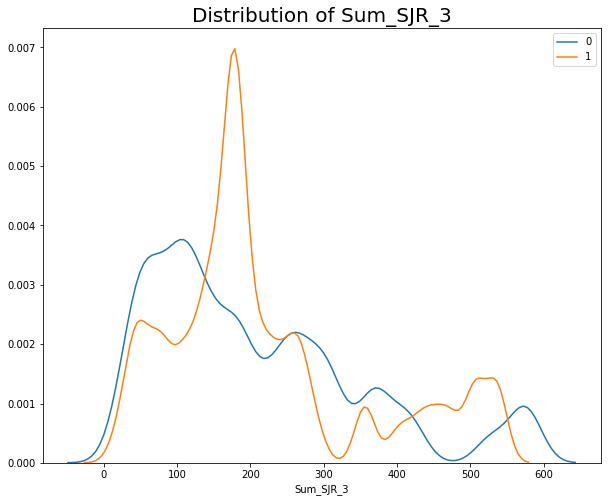

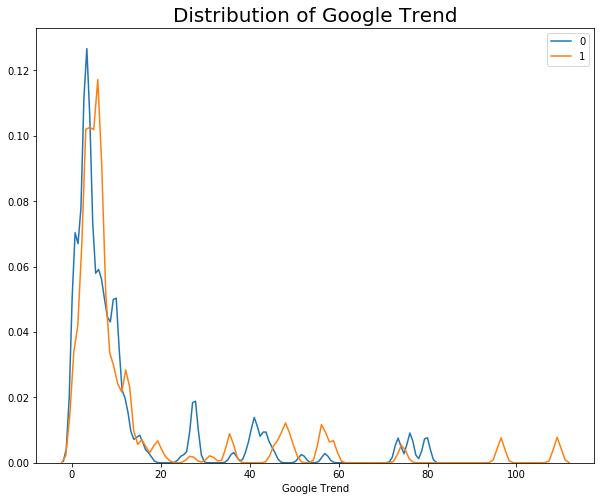

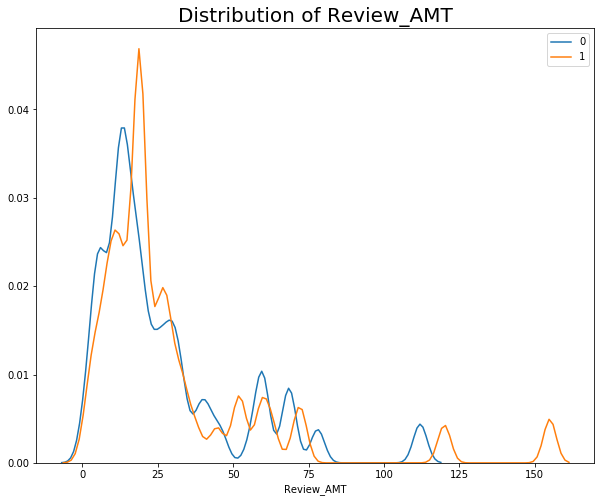

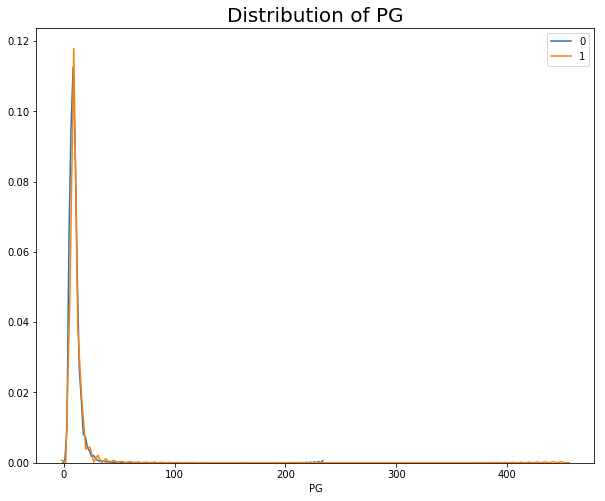

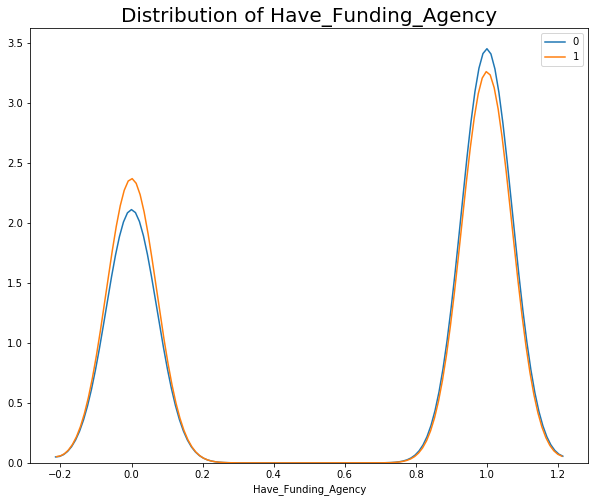

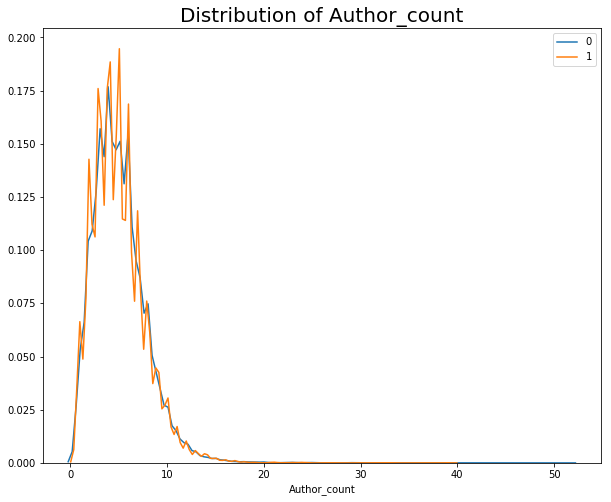

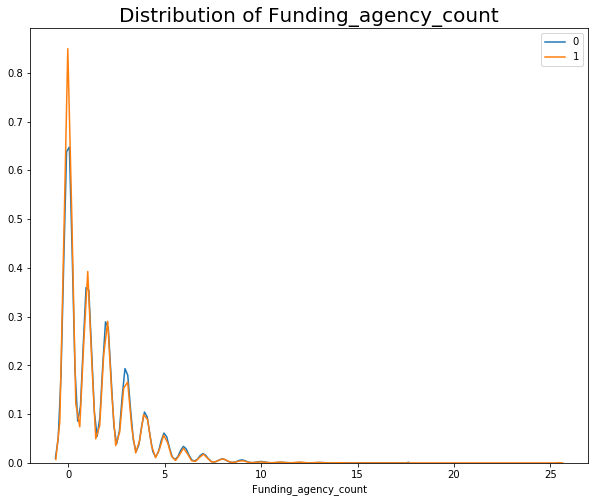

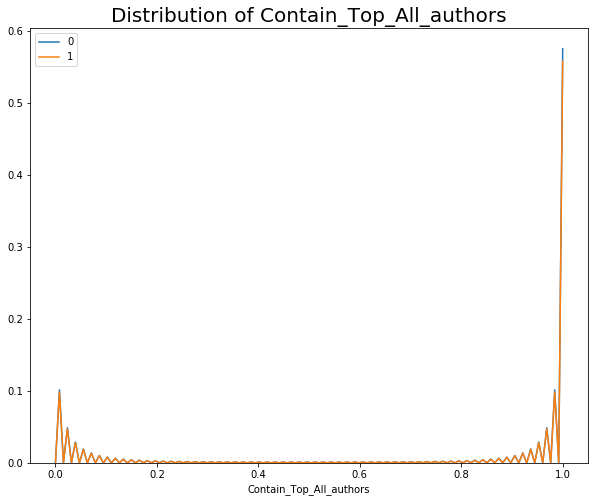

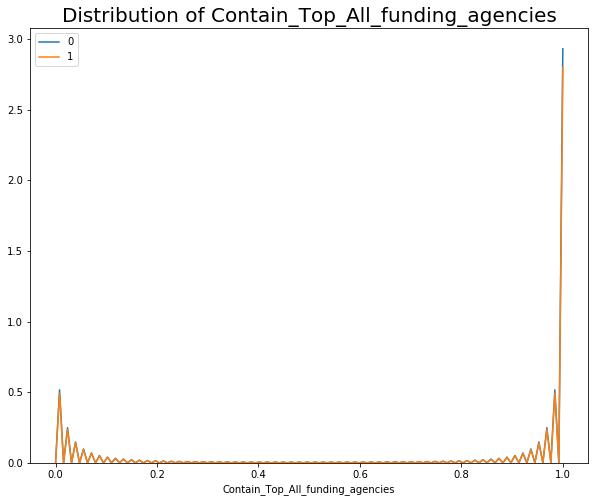

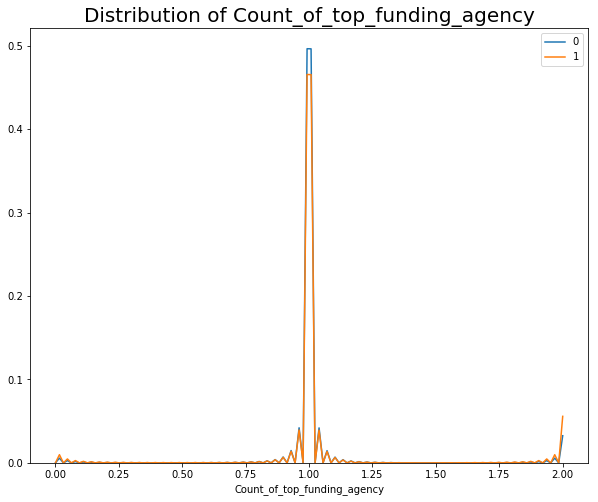

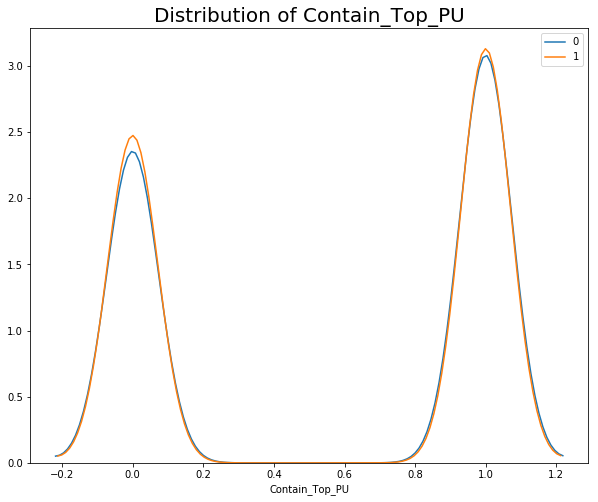

In [18]:
for col in final_data.columns:
    if (final_data[col].dtype != 'object') & (col not in ['Target','Year','Topic']):
        num_feature_distribution_plot(col_name=col, response_name='Target', data=final_data)

## 2.2 Relationship between numerical predictors: Correlation Plot

In [19]:
num_col_names = []
for col in final_data.columns:
    if (final_data[col].dtype != 'object'):
        num_col_names.append(col)
        
num_col_names.remove('Year')
num_col_names.remove('Topic')

correlation_matrix = final_data[num_col_names].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

In [20]:
# The correlation matrix shape is 24 x 24
correlation_matrix

,Citation_feature,Topic_num,Five_Year_Percent,Three_Year_Percent,Sum_SJR,Avg_SJR,Growth_Rate,Citation_Growth_Rate,Year_Growth_Rate,Target,...,Google Trend,Review_AMT,PG,Have_Funding_Agency,Author_count,Funding_agency_count,Contain_Top_All_authors,Contain_Top_All_funding_agencies,Count_of_top_funding_agency,Contain_Top_PU
Citation_feature,1.000000,-0.408237,0.652311,0.550376,-0.162654,0.088902,0.087995,0.367518,0.161274,-0.044135,...,-0.124479,-0.201031,-0.060157,-0.301172,-0.095320,-0.236913,0.012868,-0.026478,-0.027219,-0.013505
Topic_num,-0.408237,1.000000,-0.347669,-0.295169,0.551821,-0.145744,-0.088544,-0.122778,-0.219641,0.126435,...,0.355607,0.819845,0.136603,0.324862,0.151308,0.277109,-0.020622,0.025503,0.026351,0.044535
Five_Year_Percent,0.652311,-0.347669,1.000000,0.928188,-0.022221,0.162148,0.105749,0.161792,0.098993,0.024988,...,-0.057791,-0.169799,-0.068487,-0.226237,-0.081883,-0.186766,0.009548,-0.018320,-0.019346,0.005751
Three_Year_Percent,0.550376,-0.295169,0.928188,1.000000,-0.020931,0.116573,0.069565,0.196552,0.074257,0.020758,...,-0.037545,-0.120863,-0.052635,-0.181102,-0.060434,-0.146720,0.010108,-0.017625,-0.017919,0.009289
Sum_SJR,-0.162654,0.551821,-0.022221,-0.020931,1.000000,0.654366,-0.057969,-0.046906,-0.135297,0.019276,...,-0.007299,0.397123,0.051328,0.232610,0.072427,0.193703,-0.006955,0.028556,0.026304,0.042008
Avg_SJR,0.088902,-0.145744,0.162148,0.116573,0.654366,1.000000,0.017501,0.028500,0.010094,-0.012393,...,-0.317618,-0.159863,-0.045005,0.031043,-0.045273,0.018137,0.007049,0.016299,0.012397,0.011050
Growth_Rate,0.087995,-0.088544,0.105749,0.069565,-0.057969,0.017501,1.000000,-0.511017,0.620977,0.564586,...,-0.032057,-0.125650,-0.037006,-0.090696,-0.037883,-0.074883,0.006258,-0.011178,-0.011517,-0.014687
Citation_Growth_Rate,0.367518,-0.122778,0.161792,0.196552,-0.046906,0.028500,-0.511017,1.000000,-0.226987,-0.355802,...,0.013985,-0.022922,-0.007694,-0.032424,-0.007437,-0.024792,-0.002159,-0.009797,-0.009694,0.004513
Year_Growth_Rate,0.161274,-0.219641,0.098993,0.074257,-0.135297,0.010094,0.620977,-0.226987,1.000000,0.027274,...,-0.084457,-0.209714,-0.055756,-0.145333,-0.056146,-0.120776,0.006791,-0.015888,-0.016936,-0.024637
Target,-0.044135,0.126435,0.024988,0.020758,0.019276,-0.012393,0.564586,-0.355802,0.027274,1.000000,...,0.054212,0.060655,0.004279,-0.042015,-0.016842,-0.031668,-0.000795,-0.002695,-0.001670,-0.008296


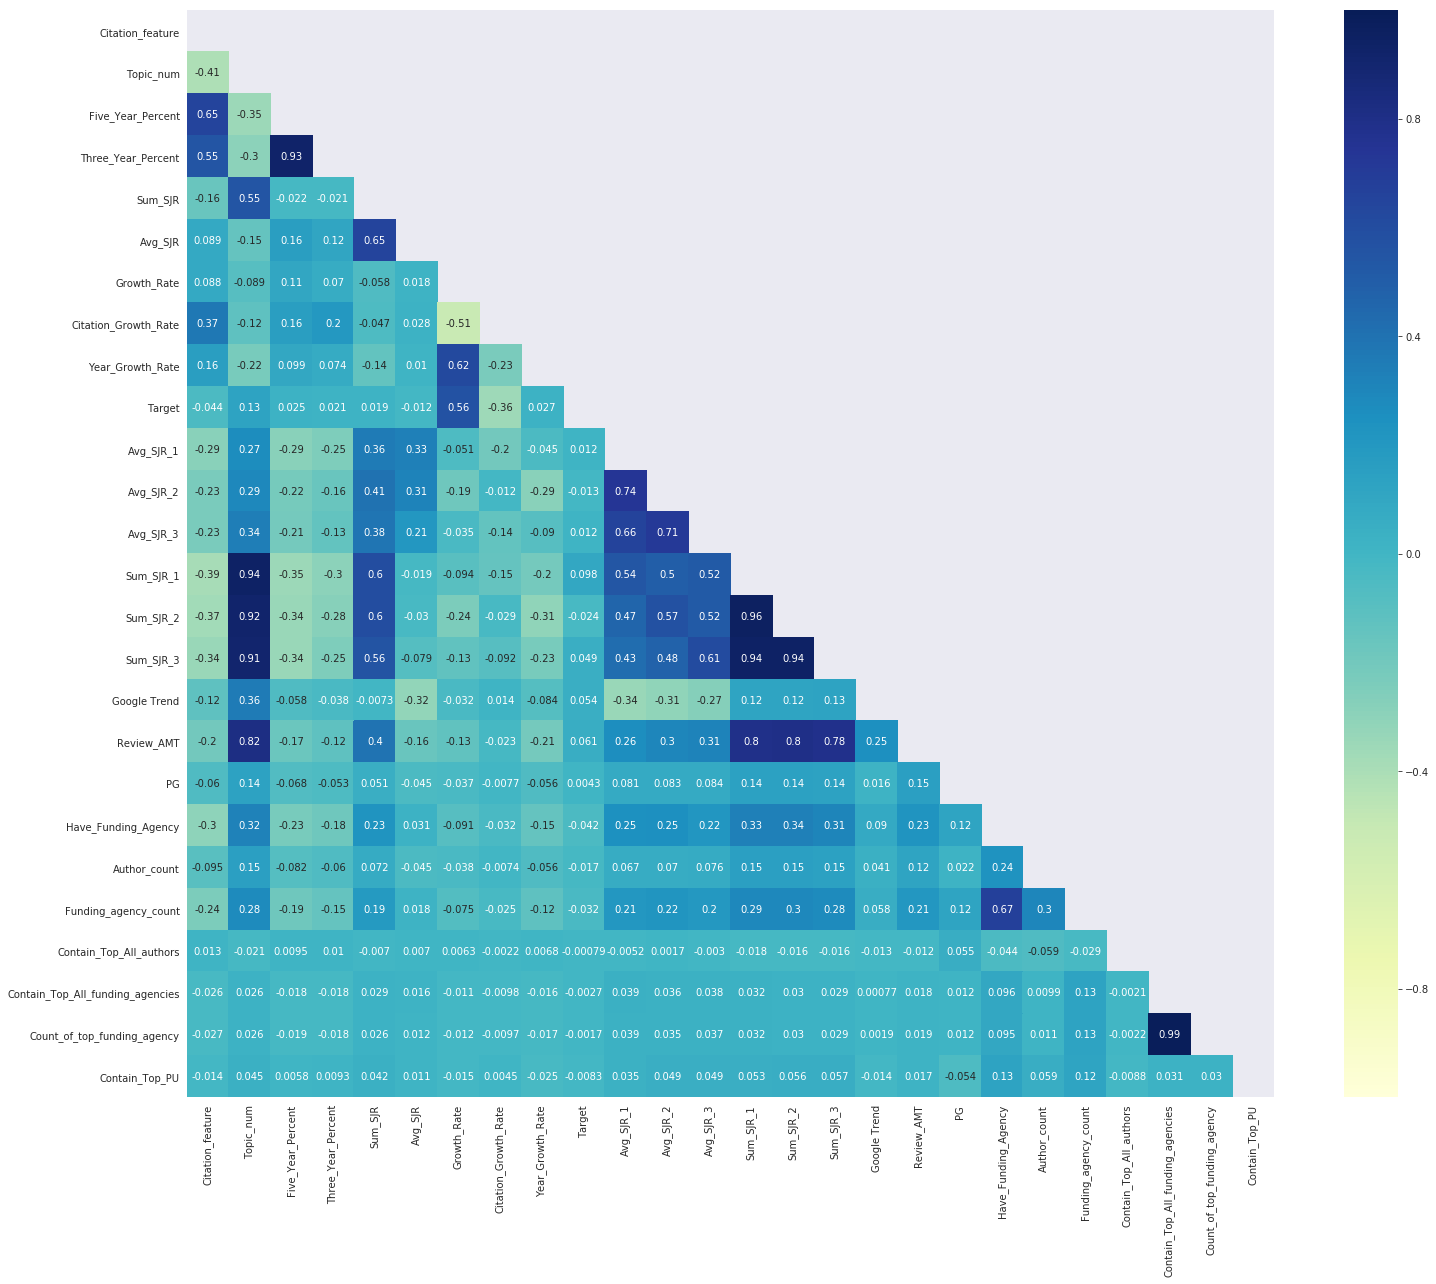

In [21]:
# Correlation plot helps me to inspect the relationship among numerical features.
# There might be a multicollinearity issue existed!
# For instance, perimeter_mean and radius_mean have a perfect positive correlation!
with sb.axes_style("darkgrid"):
    fig = plt.figure(figsize=(25,20))
    ax = sb.heatmap(correlation_matrix, mask = mask, 
                    vmin = -1, vmax = 1, square = True,
                    annot = True, cmap = "YlGnBu")
    plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

## 2.3 Distribution plots - categorical features

In [22]:
# Helper function for inspecting the relationship between categorical features 
# and the response variable.
def cate_feature_distribution_plot(col_name, response_name, data):
    pd.crosstab(data[col_name], data[response_name]).plot(kind='bar')
    plt.title('Distribution of '+ col_name, fontsize=20)
    plt.xlabel('')
    plt.show()

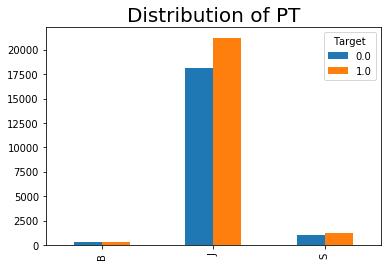

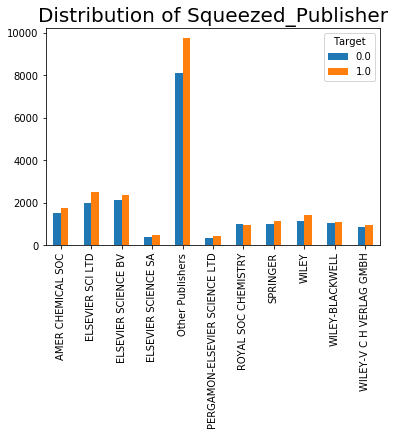

In [23]:
for col in final_data.columns:
    if (final_data[col].dtype == 'object') & (col != 'Topic_Year'):
        cate_feature_distribution_plot(col_name=col, response_name='Target', data=final_data)

## 2.4 Hypothesis testing - two sample t-test for numerical features

In [24]:
# Helper function for performing an f-test to compare two sample variances.
def f_test_two_p_variance(var1, var2, n1, n2, alpha_level):
    '''
    Perform the F-test for comparing variances between two samples.
    Outputs: F ratio, p-value, and the confidence interval given an alpha level.
    
    var1: the variance of the population 1
    var2: the variance of the population 2
    n1: sample size of the population 1
    n2: sample size of the population 2
    alpha_level: can be either 0.1, 0.05, or 0.1
    '''
    # F test statistic
    F_ratio = var1 / var2
    
    # p-value (two-sided test: the interest is to compare whether two variances are equal)
    p_value = min(f.cdf(F_ratio, n1-1, n2-1), 1 - f.cdf(F_ratio, n1-1, n2-1))
    p_value = p_value*2

    # 95% C.I.
    upper = 1 / (f.ppf(alpha_level/2, n1-1, n2-1)) * F_ratio
    lower = 1 / (f.ppf(1 - (alpha_level/2), n1-1, n2-1)) * F_ratio
    
    return F_ratio, p_value, (lower, upper)

In [25]:
# Loop into numerical columns.
unequal_var = []
equal_var = []
for num_col in num_col_names:
    if num_col != 'Target':
        f_results = f_test_two_p_variance(var1=final_data[final_data.Target == 0][num_col].var(), 
                                          var2=final_data[final_data.Target == 1][num_col].var(), 
                                          n1=final_data[final_data.Target == 0][num_col].count(), 
                                          n2=final_data[final_data.Target == 1][num_col].count(), 
                                          alpha_level=0.05)
        print('Column name: {}.'.format(num_col))
        print('F ratio: {}.'.format(f_results[0]))
        print('p-value: {}.'.format(f_results[1]))
        print('95 C.I. {}.'.format(f_results[2]))
        if f_results[1] <= 0.05:
            print('Decision: reject H0, two variances are unequal.')
            unequal_var.append(num_col)
        else: 
            print('Decision: do not reject H0, two variances are equal.')
            equal_var.append(num_col)
        print('----------------------------------------------------')

Column name: Citation_feature.
F ratio: 1.0247055537498804.
p-value: 0.07686087643311224.
95 C.I. (0.9973722340536328, 1.052818117857675).
Decision: do not reject H0, two variances are equal.
----------------------------------------------------
Column name: Topic_num.
F ratio: 0.9390189266899808.
p-value: 5.251502074696639e-06.
95 C.I. (0.9139712391566024, 0.9647806976478926).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: Five_Year_Percent.
F ratio: 0.9994066998149145.
p-value: 0.9659844152523964.
95 C.I. (0.9727482097416963, 1.0268251956115755).
Decision: do not reject H0, two variances are equal.
----------------------------------------------------
Column name: Three_Year_Percent.
F ratio: 1.1072640910438991.
p-value: 1.4566126083082054e-13.
95 C.I. (1.0777285788395168, 1.1376416298693877).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: Sum_SJR.
F rat

In [26]:
# Perform two sample t-test to see whether they have 'different' means.
# If they are different to each other in the aspect of mean given a predictor, 
# then it might indicate this predictor has some prediction power 
# on the response variable

# Collecting results.
t_test_results = np.array([])
t_test_p_values = np.array([])
num_col_names = np.array([])

# Loop into numerical columns - unequal variance case.
for num_col in unequal_var:
    t_test_results = np.append(t_test_results,
                               (ttest_ind(a=final_data[final_data.Target == 0][num_col], 
                                          b=final_data[final_data.Target == 1][num_col], 
                                          equal_var=False))[0])
    t_test_p_value = ttest_ind(a=final_data[final_data.Target == 0][num_col], 
                               b=final_data[final_data.Target == 1][num_col], 
                               equal_var=False)[1]
    t_test_p_values = np.append(t_test_p_values, t_test_p_value)
    num_col_names = np.append(num_col_names, num_col)
    # Decision (reject or not reject H0)
    if t_test_p_value <= 0.05:
        print('Column name: {}.'.format(num_col))
        print('Decision: reject H0, two means are unequal.')
        print('p-value: {}.'.format(t_test_p_value))
    else:
        print('Column name: {}.'.format(num_col))
        print('Decision: do not reject H0, two means are equal.')
        print('p-value: {}.'.format(t_test_p_value))
    print('-------------------------------------------')

# Loop into numerical columns - equal variance case.
for num_col in equal_var:
    t_test_results = np.append(t_test_results,
                               (ttest_ind(a=final_data[final_data.Target == 0][num_col], 
                                          b=final_data[final_data.Target == 1][num_col], 
                                          equal_var=True))[0])
    t_test_p_value = ttest_ind(a=final_data[final_data.Target == 0][num_col], 
                               b=final_data[final_data.Target == 1][num_col], 
                               equal_var=True)[1]
    t_test_p_values = np.append(t_test_p_values, t_test_p_value)
    num_col_names = np.append(num_col_names, num_col)
    # Decision (reject or not reject H0)
    if t_test_p_value <= 0.05:
        print('Column name: {}.'.format(num_col))
        print('Decision: reject H0, two means are unequal.')
        print('p-value: {}.'.format(t_test_p_value))
    else:
        print('Column name: {}.'.format(num_col))
        print('Decision: do not reject H0, two means are equal.')
        print('p-value: {}.'.format(t_test_p_value))
    print('-------------------------------------------')

Column name: Topic_num.
Decision: reject H0, two means are unequal.
p-value: 8.620250651499255e-151.
-------------------------------------------
Column name: Three_Year_Percent.
Decision: reject H0, two means are unequal.
p-value: 2.132324539332544e-05.
-------------------------------------------
Column name: Avg_SJR.
Decision: reject H0, two means are unequal.
p-value: 0.010946210408991448.
-------------------------------------------
Column name: Growth_Rate.
Decision: reject H0, two means are unequal.
p-value: 0.0.
-------------------------------------------
Column name: Citation_Growth_Rate.
Decision: reject H0, two means are unequal.
p-value: 0.0.
-------------------------------------------
Column name: Year_Growth_Rate.
Decision: reject H0, two means are unequal.
p-value: 2.9147169198171978e-08.
-------------------------------------------
Column name: Avg_SJR_1.
Decision: reject H0, two means are unequal.
p-value: 0.012299632312593643.
-------------------------------------------
C

In [27]:
# Absolute t-test statistics.
abs(t_test_results)[abs(t_test_results).argsort()]

array([  0.16315238,   0.34321525,   0.5529736 ,   0.88102301,
         1.70540611,   2.35537841,   2.50354234,   2.54452711,
         2.5601817 ,   3.45654418,   3.96296914,   4.25106431,
         4.83710509,   5.13802928,   5.54761632,   6.50526815,
         8.6553437 ,   9.08093722,  10.01311296,  11.33631555,
        12.72401451,  20.19058257,  26.26312279,  75.00891563,
       143.01199943])

In [28]:
# Column names: From the least to the most important numerical feature.
num_col_names[abs(t_test_results).argsort()]

array(['Contain_Top_All_authors', 'Count_of_top_funding_agency',
       'Contain_Top_All_funding_agencies', 'PG', 'Contain_Top_PU',
       'Avg_SJR_3', 'Avg_SJR_1', 'Avg_SJR', 'Avg_SJR_2', 'Author_count',
       'Sum_SJR', 'Three_Year_Percent', 'Sum_SJR_2', 'Five_Year_Percent',
       'Year_Growth_Rate', 'Funding_agency_count', 'Have_Funding_Agency',
       'Citation_feature', 'Sum_SJR_3', 'Google Trend', 'Review_AMT',
       'Sum_SJR_1', 'Topic_num', 'Citation_Growth_Rate', 'Growth_Rate'],
      dtype='<U32')

## 2.5 Hypothesis testing - chi-square test for categorical features

In [29]:
for col in final_data.columns:
    if final_data[col].dtype == 'object':
        print(col)

Topic_Year
PT
Squeezed_Publisher


In [30]:
# Collecting results.
chi_square_test_results = np.array([])
cate_col_names = np.array([])

# Loop into categorical features.
for col in final_data.columns:
    if (final_data[col].dtype == 'object') & (col != 'Topic_Year'):
        chi_square_test_results = np.append(chi_square_test_results, 
                                            chi2_contingency(pd.crosstab(final_data[col], final_data['Target']).values)[0])
        chi_square_test_p = chi2_contingency(pd.crosstab(final_data[col], final_data['Target']).values)[1]
        cate_col_names = np.append(cate_col_names, col)
        
        if chi_square_test_p <= 0.05:
            print('Column name: {}.'.format(col))
            print('Decision: reject H0, {} and {} are not independent to each other.'.
                 format(col, 'Target (trend or not trend)'))
            print('p-value: {}.'.format(chi_square_test_p))
        else:
            print('Column name: {}.'.format(col)) 
            print('Decision: do not reject H0, {} and {} are independent to each other.'.
                  format(col, 'Target (trend or not trend)'))
            print('p-value: {}.'.format(chi_square_test_p))
        print('---------------------------------------------------------------------------------------------')

Column name: PT.
Decision: do not reject H0, PT and Target (trend or not trend) are independent to each other.
p-value: 0.7834161712569998.
---------------------------------------------------------------------------------------------
Column name: Squeezed_Publisher.
Decision: reject H0, Squeezed_Publisher and Target (trend or not trend) are not independent to each other.
p-value: 9.845776107419037e-08.
---------------------------------------------------------------------------------------------


## 2.6 Overall feature selection summary

#### Numerical Features
- P-value larger than 0.05

| Column name | p-value |
| -- | -- |
| Contain_Top_All_authors| 0.8703
| Count_of_top_funding_agency | 0.7314
| Contain_Top_All_funding_agencies | 0.5803
| PG | 0.3783
| **Contain_Top_PU** | **0.0881 (Close to 0.05)**

- P-value less than 0.05

| Column name | Rank | p-value 
| -- | -- | -- 
| Avg_SJR_3 | 20 | **0.0185 (Close to 0.05)**
| Avg_SJR_1 | 19 | **0.0123 (Close to 0.05)**
| Avg_SJR | 18 | **0.0109 (Close to 0.05)**
| Avg_SJR_2 | 17 | **0.0104 (Close to 0.05)**
| Author_count | 16
| Sum_SJR | 15
| Three_Year_Percent | 14
| Sum_SJR_2 | 13 
| Five_Year_Percent | 12
| Year_Growth_Rate | 11 
| Funding_agency_count | 10
| Have_Funding_Agency | 9 
| Citation_feature | 8 
| Sum_SJR_3 | 7 
| Google Trend | 6
| Review_AMT | 5 
| Sum_SJR_1 | 4 
| Topic_num | 3 
| Citation_Growth_Rate | 2 
| Growth_Rate | **1**

#### Categorical Features
- P-value larger than 0.05

| Column name | p-value |
| -- | -- |
| PT | 0.7834

- P-value less than 0.05

| Column name | p-value |
| -- | -- |
| **Squeezed_Publisher** | **0.03674 (Close to 0.05)**